Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
#Divided into train and validation 

from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.8)
train.shape, val.shape

((47520, 41), (11880, 41))

In [4]:
import numpy as np
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population','amount_tsh']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id','wpt_name', 'recorded_by']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
        
    
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

    

In [5]:
# The status_group column is the target
target = 'status_group'


# # Get a dataframe with all train columns except the target
# train_features = train.drop(columns=[target])

# # Get a list of the numeric features
# numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# # Get a series with the cardinality of the nonnumeric features
# cardinality = train_features.select_dtypes(exclude='number').nunique()

# # Get a list of all categorical features with cardinality <= 50
# categorical_features = cardinality[cardinality <= 50].index.tolist()

# # Combine the lists 
# features = numeric_features + categorical_features


#Using all features, apart from the target
features=train.columns.drop(target)



X_train = train[features]
y_train = train[target]
X_val=val[features]
y_val=val[target]
X_test = test[features]

In [6]:
import warnings
warnings.filterwarnings('ignore')

import category_encoders as ce
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


pipeline = make_pipeline(
     ce.OrdinalEncoder(), 
     SimpleImputer(strategy='mean'), 
     StandardScaler(),
     RandomForestClassifier(random_state=0, n_jobs=-1)

    )
# Fit on train, score on val
pipeline.fit(X_train, y_train)
print(f'Validation Accuracy is {pipeline.score(X_val, y_val):.4f}')

Validation Accuracy is 0.8125


In [8]:
import sklearn
sklearn.__version__

'0.22.1'

In [9]:
from sklearn.metrics import plot_confusion_matrix

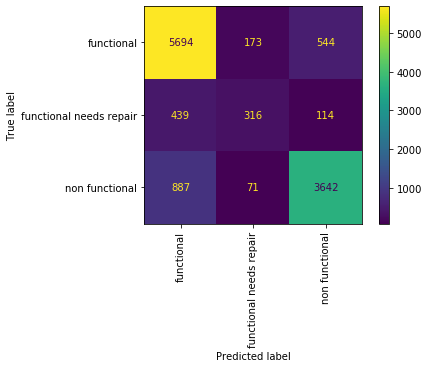

In [11]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [13]:
accuracy =(5694+316+3642)/len(y_val)
accuracy
#precision 
#recall = 

0.8124579124579124

In [15]:
y_pred = pipeline.predict(X_val)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6411
functional needs repair       0.56      0.36      0.44       869
         non functional       0.85      0.79      0.82      4600

               accuracy                           0.81     11880
              macro avg       0.74      0.68      0.70     11880
           weighted avg       0.81      0.81      0.81     11880



<h3>Threshholds</h3>

In [17]:
#Redefine our target 

y_train=y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize='True')

False    0.543939
True     0.456061
Name: status_group, dtype: float64

In [18]:
len(val)==len(test)

False

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'basin',
                                      'subvillage', 'region', 'lga', 'ward',
                                      'public_meeting', 'scheme_management',
                                      'scheme_name', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                               

In [20]:
y_pred=pipeline.predict(X_val)

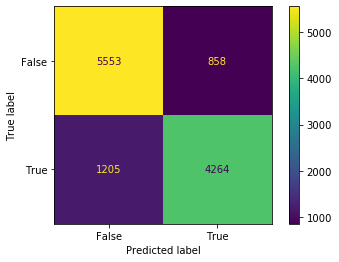

In [21]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f')

In [22]:
pipeline.predict(X_val)

array([False,  True,  True, ..., False,  True, False])

In [23]:
pipeline.predict_proba(X_val)

array([[0.98, 0.02],
       [0.14, 0.86],
       [0.22, 0.78],
       ...,
       [0.76, 0.24],
       [0.33, 0.67],
       [0.69, 0.31]])

In [24]:
pipeline.predict_proba(X_val)[:,1]

array([0.02, 0.86, 0.78, ..., 0.24, 0.67, 0.31])

In [25]:
threshold=0.50
pipeline.predict_proba(X_val)[:,1]>threshold

array([False,  True,  True, ..., False,  True, False])

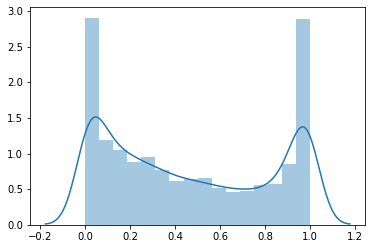

In [26]:
import seaborn as sns

y_pred_proba=pipeline.predict_proba(X_val)[:,1]
sns.distplot(y_pred_proba);

False    8039
True     3841
dtype: int64

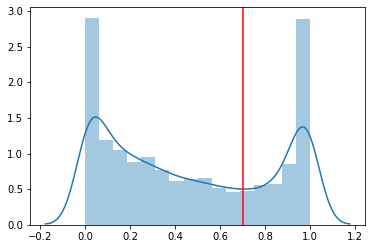

In [29]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

threshold=0.7

y_pred=y_pred_proba > threshold

ax=sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [37]:
#make a widget to control it 
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed 
import seaborn as sns 
from sklearn.metrics import confusion_matrix 
from sklearn.utils.multiclass import unique_labels


def my_confusion_matrix(y_true, y_pred):
    labels=unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index=[f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                        columns=columns, index=index
                        )
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred=y_pred_proba > threshold
    ax=sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    my_confusion_matrix(y_true, y_pred)


interact(set_threshold, 
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba),
        threshold=(0,1,0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [56]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [57]:
pd.DataFrame({'False Positive Rate': fpr,
              'True Positive Rate': tpr,
             'Threshold': thresholds
             })

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.000000
1,0.000624,0.140611,1.000000
2,0.001092,0.208630,0.990000
3,0.001092,0.208813,0.988333
4,0.002340,0.261474,0.980000
...,...,...,...
128,0.791920,0.989943,0.030000
129,0.792076,0.989943,0.025000
130,0.834815,0.992869,0.020000
131,0.888317,0.997074,0.010000


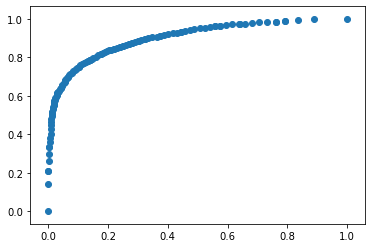

In [58]:
plt.scatter(fpr,tpr)

In [61]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.9030868074816212